In [22]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Import your preprocess function (if in another file, use %run or copy it here)
from process import preprocess_gdf_folder



In [23]:
import torch

# Define your architecture exactly as used in training
class EnhancedEEGCNNV3(nn.Module):
    def __init__(self, num_classes=4):
        super(EnhancedEEGCNNV3, self).__init__()

        self.act = nn.SiLU()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.se_fc1 = nn.Linear(256, 64)
        self.se_fc2 = nn.Linear(64, 256)

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 8 * 2, 256)  # make sure this matches feature map size
        self.fc2 = nn.Linear(256, num_classes)

    def se_block(self, x):
        b, c, _, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.act(self.se_fc1(y))
        y = torch.sigmoid(self.se_fc2(y)).view(b, c, 1, 1)
        return x * y

    def forward(self, x):
        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        x = self.se_block(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(self.act(self.fc1(x)))
        x = self.fc2(x)
        return x




In [24]:
# Load checkpoint into the correct model
model = EnhancedEEGCNNV3(num_classes=4)
model.load_state_dict(torch.load("cnn_eeg_model.pth", map_location="cpu"))
model.eval()


EnhancedEEGCNNV3(
  (act): SiLU()
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (se_fc1): Linear(in_features=256, out_features=64, bias=True)
  (se_fc2): Linear(in_features=64, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linea

In [27]:
# Change this path depending on TRAIN or EVAL
# folder_path = "data/GDF file/2a_train/A01T.gdf"   # or "./data/eval"

X, y, subject_ids = preprocess_gdf_folder("data/GDF file/2a_train")


print("X shape:", X.shape)   # (N, 120, 32, 3)
print("y shape:", y.shape)



📄 Processing A01T.gdf (Subject 0)
✅ Extracted 5733 samples from A01T.gdf

📄 Processing A02T.gdf (Subject 1)
✅ Extracted 5670 samples from A02T.gdf

📄 Processing A03T.gdf (Subject 2)
✅ Extracted 5670 samples from A03T.gdf

📄 Processing A04T.gdf (Subject 3)
✅ Extracted 5502 samples from A04T.gdf

📄 Processing A05T.gdf (Subject 4)
✅ Extracted 5502 samples from A05T.gdf

📄 Processing A06T.gdf (Subject 5)
✅ Extracted 4599 samples from A06T.gdf

📄 Processing A07T.gdf (Subject 6)
✅ Extracted 5691 samples from A07T.gdf

📄 Processing A08T.gdf (Subject 7)
✅ Extracted 5544 samples from A08T.gdf

📄 Processing A09T.gdf (Subject 8)
✅ Extracted 4977 samples from A09T.gdf

🎯 Finished preprocessing.
🟢 X shape: (48888, 120, 32, 3), y shape: (48888,), subject_ids shape: (48888,)
X shape: (48888, 120, 32, 3)
y shape: (48888,)


In [28]:
# Convert data to torch format (N, C, H, W)
X_torch = torch.tensor(X.transpose(0, 3, 1, 2))

with torch.no_grad():
    outputs = model(X_torch)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

print("Predictions shape:", preds.shape)


Predictions shape: (48888,)


In [29]:
if len(y) > 0:
    acc = np.mean(preds == y)
    print(f"✅ Accuracy: {acc*100:.2f}%")
else:
    print("⚠ No ground truth labels available (evaluation set). Showing predictions only.")


✅ Accuracy: 98.74%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2039104..4.325581].


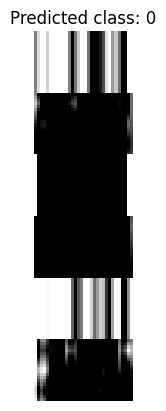

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5305327..4.1810327].


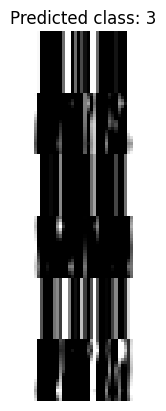

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4917352..2.7835078].


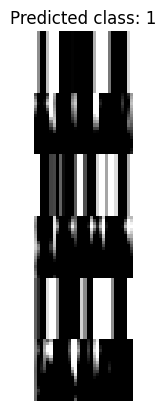

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.308691..3.0806534].


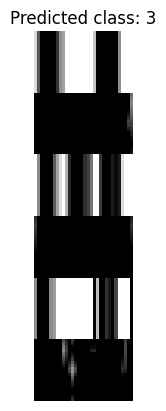

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1929353..2.3830516].


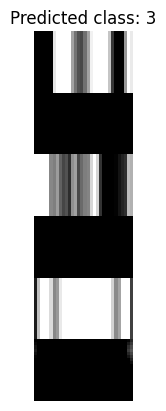

In [30]:
for i in range(min(5, len(preds))):
    plt.imshow(X[i])   # EEG spectrogram image
    plt.title(f"Predicted class: {preds[i]}")
    plt.axis("off")
    plt.show()
